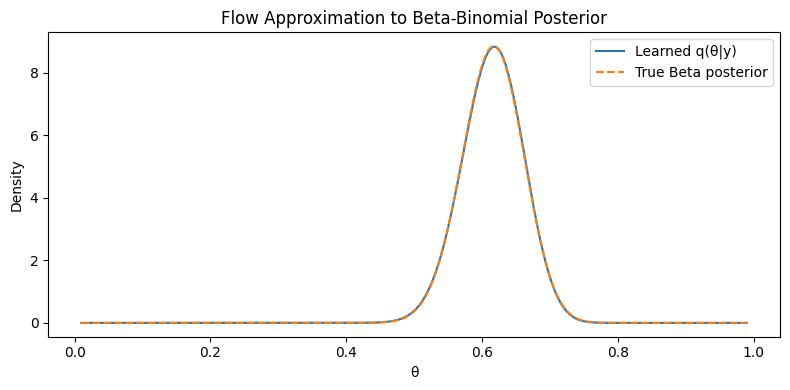

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.stats import beta as beta_dist
import numpy as np

# -------- Base class for Flow --------
class BaseFlow(nn.Module):
    def __init__(self):
        super().__init__()

    def sample(self, batch_size, y_obs):
        raise NotImplementedError

    def eval_log_prob(self, x_grid, y_obs):
        raise NotImplementedError

# -------- Affine Flow in Logit Space --------
class AffineFlowLogit(BaseFlow):
    def __init__(self, obs_dim):
        super().__init__()
        self.linear = nn.Linear(obs_dim, 2)

    def _get_params(self, y_obs):
        params = self.linear(y_obs.unsqueeze(0))  # (1, 2)
        log_scale = params[0, 0]
        shift = params[0, 1]
        scale = torch.exp(log_scale)
        return scale, shift

    def sample(self, batch_size, y_obs):
        z = torch.randn(batch_size)
        scale, shift = self._get_params(y_obs)
        logit_theta = scale * z + shift
        theta = torch.sigmoid(logit_theta).clamp(1e-6, 1 - 1e-6)

        log_qz = torch.distributions.Normal(0, 1).log_prob(z)
        log_jacobian = torch.log(theta * (1 - theta))
        log_q = log_qz - torch.log(scale) - log_jacobian
        return theta, log_q

    def eval_log_prob(self, x_grid, y_obs):
        scale, shift = self._get_params(y_obs)
        x_t = torch.tensor(x_grid)
        logit_x = torch.log(x_t / (1 - x_t))
        z_x = (logit_x - shift) / scale
        log_qz = torch.distributions.Normal(0, 1).log_prob(z_x)
        log_qx = log_qz - torch.log(scale) - torch.log(x_t * (1 - x_t))
        return log_qx.exp().detach().numpy()

# -------- Training Function --------
def train_flow(flow, y_obs, alpha0, beta0, n_trials, n_epochs=1000, n_samples=1000, lr=1e-3):
    optimizer = optim.Adam(flow.parameters(), lr=lr)
    N = y_obs.shape[0]

    for epoch in range(n_epochs):
        optimizer.zero_grad()
        theta, log_q = flow.sample(n_samples, y_obs)

        # Prior: Beta(α0, β0)
        log_prior = torch.distributions.Beta(alpha0, beta0).log_prob(theta)

        # Likelihood: product of Binomial(n_trials, θ_i)
        theta_rep = theta.unsqueeze(1).expand(-1, N)
        y_rep = y_obs.unsqueeze(0).expand_as(theta_rep)
        log_lik = torch.distributions.Binomial(n_trials, theta_rep).log_prob(y_rep).sum(dim=1)

        # ELBO
        elbo = (log_prior + log_lik - log_q).mean()
        loss = -elbo

        loss.backward()
        optimizer.step()

# -------- Plotting Function --------
def plot_density(flow, y_obs, x_grid, alpha_post, beta_post):
    q_pdf = flow.eval_log_prob(x_grid, y_obs)
    true_pdf = beta_dist.pdf(x_grid, a=alpha_post, b=beta_post)

    plt.figure(figsize=(8, 4))
    plt.plot(x_grid, q_pdf, '-', label='Learned q(θ|y)')
    plt.plot(x_grid, true_pdf, '--', label='True Beta posterior')
    plt.xlabel('θ')
    plt.ylabel('Density')
    plt.title('Flow Approximation to Beta-Binomial Posterior')
    plt.legend()
    plt.tight_layout()
    plt.show()

# -------- Main Program --------
if __name__ == "__main__":
    y_obs = torch.tensor([7., 4., 5., 8., 9., 10., 1., 2., 7., 8., 9.])
    n_trials = 10
    N = y_obs.shape[0]

    alpha0, beta0 = 2.0, 5.0
    sum_y = y_obs.sum()
    alpha_post = alpha0 + sum_y
    beta_post = beta0 + N * n_trials - sum_y

    x = np.linspace(0.01, 0.99, 500)

    flow = AffineFlowLogit(obs_dim=N)
    train_flow(flow, y_obs, alpha0, beta0, n_trials)
    plot_density(flow, y_obs, x_grid=x, alpha_post=alpha_post.item(), beta_post=beta_post.item())
